### Some Twitter Data!
Daniel Zheng

In [1]:
import seaborn as sns
import tweepy as tp
import pandas as pd

In [2]:
key, secret = open('api_key.txt').read().splitlines()

In [3]:
auth = tp.OAuthHandler(consumer_key=key, consumer_secret=secret)
api = tp.API(auth)

In [4]:
# first thought is to check out some trump tweets
trump = api.user_timeline(id='realDonaldTrump') # last 20 tweets

In [5]:
# let's take a look at the first one!

# Status object has a ._json method!

last_id = trump[0]._json['id']
print('tweet url: https://twitter.com/i/web/status/{}'.format(last_id))
# list of last 100 tweets as json objects
# probably limited by tweepy to limit stressing twitter servers
retweets = [x._json for x in api.retweets(id=last_id,count=100)] 
print('got {} retweets!'.format(len(retweets))) # ... unreliable, won't get exactly 100. oh well!

tweet url: https://twitter.com/i/web/status/915745470689005573
got 94 retweets!


In [6]:
from dateutil import parser
# creating a dataframe of these tweets
columns = ['timestamp', 'name', 'location']
formatted_retweets = []
for rt in retweets:
    # could get more user info, but keeping to this for now
    formatted_retweets.append([parser.parse(rt['created_at']), rt['user']['name'], rt['user']['location']]) 


In [7]:
tweets_df = pd.DataFrame(formatted_retweets, columns=columns)

In [8]:
tweets_df.head() 

,timestamp,name,location
0,2017-10-05 05:12:12+00:00,P. Smith,"Amherst, NY"
1,2017-10-05 05:11:55+00:00,Dan,"Rochester, NY"
2,2017-10-05 05:11:51+00:00,BLACK American🇺🇸,🇺🇸🇺🇸🇺🇸🇺🇸
3,2017-10-05 05:11:48+00:00,Jo Glenn,"Reno, NV"
4,2017-10-05 05:11:44+00:00,TrumpMonitor,


In [9]:
print(list(tweets_df['location']))

['Amherst, NY', 'Rochester, NY', '🇺🇸🇺🇸🇺🇸🇺🇸', 'Reno, NV', '', 'California', '', '', '', '', '', 'San Bernardino, CA', 'Toronto', '', 'Las Vegas, NV', '', 'Make America Great Again', '', 'Texas', '', '', 'Washington Oregon👉LibTardLand', '', '', 'New York, NY', 'Mountain View, CA', '', '', 'United States', 'Global', '', '.', 'Lehigh County, PA', 'USA', 'Washington D.C', '', '', '216', 'Thy Kingdom Come', '', 'Oregon, USA', '', '', 'Wisconsin Rapids, WI', 'Karachi', 'Canada', 'Southeast Louisiana ', 'Odense, Danmark 🇩🇰', '', '', 'USA', '', 'Los Angeles, CA.', 'Tajikistan', '', 'Wisconsin, USA', '', '', '', 'Pleasant City Ohio', '', '', 'SanFranciscoCA Lake TahoeNV', 'Las Vegas, NV', 'Poinciana, FL', 'Guayaquil, Ecuador', '', '暗黒世界 （ぶらっくわーるど）', '', '', 'La Paz - Bolivia', 'Seattle, WA', 'Houston, TX', 'St. Joseph County, Indiana', 'Las Vegas', 'Atlanta', 'Waukesha, WI', 'the world circus', 'Oklahoma, USA', 'Trumpville, USA ', '', 'Celina', '', 'ISRAEL', '', 'Planet Earth', '', 'San Antonio,

In [10]:
# looks like a bunch of empty strings when a location isn't found, so that's fine.
tweets_df = tweets_df[tweets_df['location'] != ''].reset_index(drop=True) # reset index from 0
tweets_df = tweets_df.sort_values('timestamp')
print('got locations for {} retweets'.format(len(tweets_df)))

got locations for 54 retweets


What to do now? Maybe plotting retweets on a map could be interesting!

In [11]:
from geopy.geocoders import Nominatim
import re
locator = Nominatim()
# nice package to convert words into coordinates
def get_coords(place):
    # regex attempt to help with weird location names..
    cleaned_place = ' '.join(re.split('[^a-zA-Z]', place)) 
    print(cleaned_place)
    location = locator.geocode(cleaned_place)
    if location is not None:
        return location.longitude, location.latitude
    return None

In [12]:
tweets_df['long-lat'] = tweets_df['location'].map(get_coords) # yikes this is slow
tweets_df = tweets_df[~tweets_df['long-lat'].isnull()]
print('got longitude and latitude for {} retweets'.format(len(tweets_df)))

Greater KC  Mo 
Indianapolis  IN
Bexley  London
San Antonio  TX
Planet Earth
ISRAEL
Celina
Trumpville  USA 
Oklahoma  USA
the world circus
Waukesha  WI
Atlanta
Las Vegas
St  Joseph County  Indiana
Houston  TX
Seattle  WA
La Paz   Bolivia
               
Guayaquil  Ecuador
Poinciana  FL
Las Vegas  NV
SanFranciscoCA Lake TahoeNV
Pleasant City Ohio
Wisconsin  USA
Tajikistan
Los Angeles  CA 
USA
Odense  Danmark   
Southeast Louisiana 
Canada
Karachi
Wisconsin Rapids  WI
Oregon  USA
Thy Kingdom Come
   
Washington D C
USA
Lehigh County  PA
 
Global
United States
Mountain View  CA
New York  NY
Washington Oregon LibTardLand
Texas
Make America Great Again
Las Vegas  NV
Toronto
San Bernardino  CA
California
Reno  NV
        
Rochester  NY
Amherst  NY
got longitude and latitude for 44 retweets


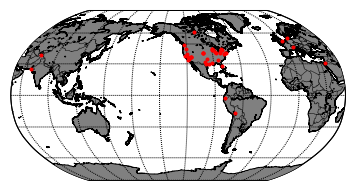

In [13]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

lons = []
lats = []

fig, ax = plt.subplots()
# 'f' for full resolution, kinda slow
world_map = Basemap(projection='robin', resolution = 'f', area_thresh = 1000.0,
              lat_0=0, lon_0=-130)
world_map.drawcoastlines()
world_map.drawcountries()
world_map.fillcontinents(color = 'gray')
world_map.drawmapboundary()
world_map.drawmeridians(np.arange(0, 360, 30))
world_map.drawparallels(np.arange(-90, 90, 30))

x,y = world_map(0, 0)
point = world_map.plot(x, y, 'ro', markersize=3)[0]

def init():
    point.set_data([], [])
    return point,
def animate(i):
    if i < len(tweets_df):
        lons.append(tweets_df.iloc[i]['long-lat'][0])
        lats.append(tweets_df.iloc[i]['long-lat'][1])
        x, y = world_map(lons, lats)
        point.set_data(x, y)
    return point,

anim = animation.FuncAnimation(plt.gcf(), animate, init_func=init,
                               frames=len(tweets_df), interval=200, blit=True)
HTML(anim.to_html5_video())


In [14]:
# would've liked to use tweepy's streaming features to livestream retweets
# download as html to view video!